In [5]:
from firedrake import *
from firedrake.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree

In [6]:
m = Mesh("../meshes/ITER.msh", dim = 2, distribution_parameters={"partition": False}, reorder = True)
m.init()

## Algorithm to find X-points:

In [ ]:
def build_dof_connectivity_map(V):
    # Builds two maps that to access from each node the neighboring cells and the nodes at their vertices (neighboring nodes)
    # param: V - function space

    # return dof_cell_map_arrays: A list containing at the i-esim position an array with the indexes of the cells that have the i-esim node as a vertex.
    # return neighbor_map_arrays: A list containing at the i-esim position an array containg the indexes of the neighboring nodes of the i-esim dof, sorted counterclockwise

    n_dofs = V.dof_count
    neighbors_map = [set() for _ in range(n_dofs)]  # list of set
    dof_cell_map =  [set() for _ in range(n_dofs)]

    cell_dofs = V.cell_node_map().values
    for cell_idx, cell in enumerate(cell_dofs):
        for i in range(len(cell)):
            # Fill dof_cell_map:
            dof1 = cell[i]
            dof_cell_map[dof1].add(cell_idx)
            # Fill neighbors map:
            for j in range(i+1,len(cell)):
                dof2 = cell[j]
                neighbors_map[dof1].add(dof2)
                neighbors_map[dof2].add(dof1)

    # Convert into lists of arrays:
    dof_cell_map_arrays = []
    neighbors_map_arrays = []

    m = V.mesh()
    coord_func = Function(VectorFunctionSpace(m, "CG", 1)).interpolate(as_vector(SpatialCoordinate(m)))

    for idx, neighbors_set in enumerate(neighbors_map):

        neighbors_array = np.array(list(neighbors_set))
        dof_cell_map_arrays.append(np.array(list(dof_cell_map[idx])))

        # Order (counter-clockwise) neighboring dofs order:
        node_coords = coord_func.dat.data_ro[idx]
        neighbor_coords = coord_func.dat.data_ro[neighbors_array]

        dx = neighbor_coords[:, 0] - node_coords[0]
        dy = neighbor_coords[:, 1] - node_coords[1]
        angles = np.arctan2(dy, dx)

        sorted_indices = np.argsort(angles)
        neighbors_map_arrays.append(neighbors_array[sorted_indices])

    return neighbors_map_arrays, dof_cell_map_arrays

In [10]:
def build_neighbors_map(V):
    # Builds two maps that to access from each node the neighboring cells and the nodes at their vertices (neighboring nodes)
    # param: V - function space

    # return: neighbor_map_sorted: A list containing at the i-esim position an array containg the indexes of the neighboring nodes of the i-esim dof, sorted counterclockwise

    n_dofs = V.dof_count
    neighbors_map = [set() for _ in range(n_dofs)]  # list of set

    cell_dofs = V.cell_node_map().values
    for cell in cell_dofs:
        for i in range(len(cell)):
            dof1 = cell[i]
            for j in range(i+1,len(cell)):
                dof2 = cell[j]
                neighbors_map[dof1].add(dof2)
                neighbors_map[dof2].add(dof1)

    # Order (counter-clockwise) neighbors order:
    neighbors_map_sorted = []
    m = V.mesh()
    coord_func = Function(VectorFunctionSpace(m, "CG", 1)).interpolate(as_vector(SpatialCoordinate(m)))

    for idx, neighbors_set in enumerate(neighbors_map):
        neighbors_array = np.array(list(neighbors_set))

        node_coords = coord_func.dat.data_ro[idx]
        neighbor_coords = coord_func.dat.data_ro[neighbors_array]

        dx = neighbor_coords[:, 0] - node_coords[0]
        dy = neighbor_coords[:, 1] - node_coords[1]
        angles = np.arctan2(dy, dx)

        sorted_indices = np.argsort(angles)
        neighbors_map_sorted.append(neighbors_array[sorted_indices])

    return neighbors_map_sorted

In [11]:
def is_saddle_point(f, idx, neighbors_map):
    # Check if the node indicated with idx is a saddle point for the function f
    # param f: function
    # param idx: index of the mesh node to be checked.
    # param neighbors_map: list that associates to a node an array with the indexes of the neighboring nodes

    neighbors_idx = neighbors_map[idx] 
    if len(neighbors_idx) < 4:
        return False

    # If grad changes sign at least 4 times, f has a saddle point in dof[idx]:
    f_node = f.dat.data_ro[idx]
    f_neighbors = f.dat.data_ro[neighbors_idx]
    grad_signs = np.sign(f_neighbors - f_node)

    # Eliminate zeros to count the number of sign changes:
    for i in range(len(grad_signs)):
        if grad_signs[i] == 0:
            grad_signs[i] = grad_signs[i-1] if i > 0 else grad_signs[-1]

    counter = 0
    for i in range(len(grad_signs)):
        next_i = (i + 1) % len(grad_signs)
        if grad_signs[i] * grad_signs[next_i] < 0:
            counter += 1

    return counter > 3    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


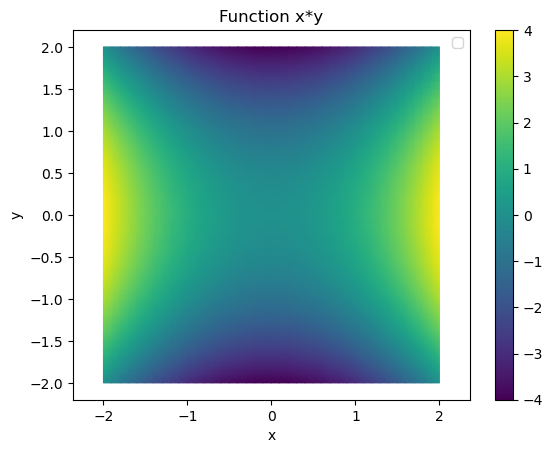

In [ ]:
# Test:
m = RectangleMesh(20, 20, 2.0, 2.0, -2.0, -2.0)
V = FunctionSpace(m, "CG", 1)
    
# z = x*y has saddle point in (0,0))
x, y = SpatialCoordinate(m)
f = Function(V).interpolate(x**2 - y**2)

fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
plt.title(r"Function x*y")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

In [14]:
neighbors_map = build_neighbors_map(V)
    
# Find closest node to the origin:
coord_func = Function(VectorFunctionSpace(m, "CG", 1)).interpolate(as_vector(SpatialCoordinate(m)))
dof_coords = coord_func.dat.data_ro[:]
distances = np.sum(dof_coords**2, axis=1)
center_node = np.argmin(distances)

print(f"Closest node to origin: {center_node}")
print(f"Coordinates: {dof_coords[center_node]}")
print(f"Function value:: {f.dat.data_ro[center_node]:.6f}")
    
is_saddle = is_saddle_point(f, center_node, neighbors_map)
print(f"Is a saddle point? {is_saddle}")

neighbors = neighbors_map[center_node]
f_center = f.dat.data_ro[center_node]
f_neighbors = f.dat.data_ro[neighbors]
print(f"Neighbor values: {f_neighbors}")
print(f"Differences: {f_neighbors - f_center}")

Closest node to origin: 219
Coordinates: [0. 0.]
Function value:: 0.000000
Is a saddle point? True
Neighbor values: [-4.00000000e-02  8.79851747e-17  4.00000000e-02 -4.00000000e-02
 -9.10382880e-17  4.00000000e-02]
Differences: [-4.00000000e-02  8.79851747e-17  4.00000000e-02 -4.00000000e-02
 -9.10382880e-17  4.00000000e-02]


## Define distance function from the plasma boundary:

In [ ]:
def vacuum_region_nodes(m,vacuum_tag):
    '''
        Extract the nodes that lie in the vacuum region inside the limiter.
    '''
    return 0


In [15]:
def identify_psi0(psi, neighbors_map, limiter_tag):
    
    V = psi.function_space()

    # limiter nodes -> DA SPOSTARE COME OGGETTO DELLA CLASSE NEL COSTRUTTORE
    limiter_nodes = DirichletBC(V, 0.0, limiter_tag).nodes
    psi0 = max(psi.dat.data[limiter_nodes])

    # Extract nodes s.t. psi>psi0
    psi_data = psi.dat.data_ro[:]
    internal_dof_idx = np.where(psi_data > psi0)[0] 

    # Identify saddle points inside the region psi>psi0
    saddle_points = []
    for idx in internal_dof_idx:
        if is_saddle_point(psi, idx, neighbors_map):
            saddle_points.append(idx)
    saddle_points = np.array(saddle_points)

    # Update psi0 if there is an X-points configuration:
    if len(saddle_points) > 0:
        psi0 = max(psi.dat.data_ro[saddle_points])
    return psi0

Ora manca da modificare compute intersections per "tagliare fuori" i rami della parte non chiusa della separatrix

In [16]:
def interpolate_edge(p1, p2, v1, v2, c):
    t = (c - v1) / (v2 - v1)
    return (1 - t) * p1 + t * p2

In [17]:
def compute_intersections(f,c,neighbors_map,idx):

    V = f.function_space()
    mesh = V.mesh()

    # DOF coordinates:
    coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
    dof_coords = coord_func.dat.data_ro[:]
    f_vals = f.dat.data_ro[:]

    # === Trova intersezioni f = c su edge
    intersections = []
    queue = {idx}
    visited = set()

    while queue:

        dof = queue.pop()
        visited.add(dof)    

        p1 = dof_coords[dof]
        f1 = f_vals[dof]

        for neighbor in neighbors_map[dof]:

            if neighbor in visited:
                continue

            f2 = f_vals[neighbor]
            if (f1 - c) * (f2 - c) <= 0:  # cambio di segno ⇒ intersezione
                p2 = dof_coords[neighbor]
                pt = interpolate_edge(p1, p2, f1, f2, c)
                intersections.append(pt)
            else:
                queue.add(neighbor)
    
    return np.array(intersections)

Chosen point coordinates: [1.4 0. ]


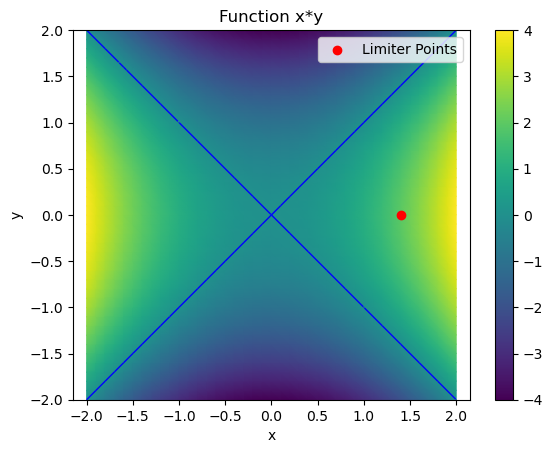

In [ ]:
# Test:
m = RectangleMesh(20, 20, 2.0, 2.0, -2.0, -2.0)
V = FunctionSpace(m, "CG", 1)
    
# z = x*y has saddle point in (0,0))
x, y = SpatialCoordinate(m)
f = Function(V).interpolate(x**2 - y**2)

# Identify a point in the right side of the "X" contour line:
coord_func = Function(VectorFunctionSpace(m, "CG", 1)).interpolate(as_vector(SpatialCoordinate(m)))
dof_coords = coord_func.dat.data_ro[:]
for i,p in enumerate(dof_coords):
    if p[1]==0 and p[0]>1.4 and p[0]<1.5:
        idx = i
        pt = p

print(f'Chosen point coordinates: {pt}')

fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
tricontour(f, levels=[0], colors='blue', linewidths=1, axes=ax)
plt.scatter(pt[0], pt[1], color='red', label='starting node')
plt.title(r"Function x*y")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

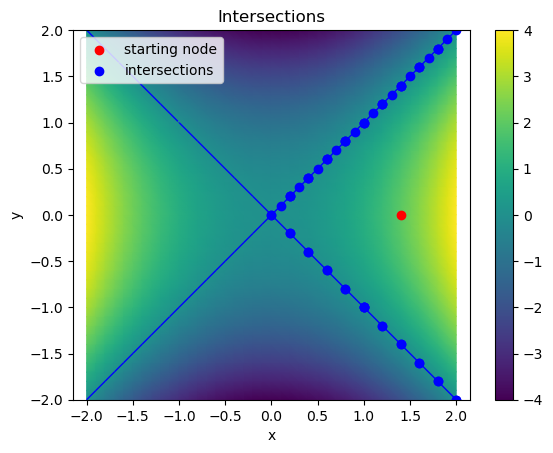

In [28]:
# Try to identify the intersections with f=0 contour line:
neighbors_map = build_neighbors_map(V)
intersections = compute_intersections(f,0.0,neighbors_map,idx)

# plot:
fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
tricontour(f, levels=[0], colors='blue', linewidths=1, axes=ax)
plt.scatter(pt[0], pt[1], color='red', label='starting node')
plt.scatter(*zip(*intersections), color='blue', label='intersections')
plt.title(r"Intersections")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

In [29]:
def compute_intersections_OLD_VERSION(f,c):

    V = f.function_space()
    mesh = V.mesh()

    # === Coordinate dei DOF
    coord_func = Function(VectorFunctionSpace(mesh, "CG", 1)).interpolate(as_vector(SpatialCoordinate(mesh)))
    dof_coords = coord_func.dat.data_ro[:]
    f_vals = f.dat.data_ro[:]

    # === Ottieni la mappa dei DOF per ogni cella
    cell_dofs = V.cell_node_map().values  # shape (num_cells, 3)

    # === Trova intersezioni f = c su edge
    intersections = []

    for dofs in cell_dofs:
        for i, j in [(0, 1), (1, 2), (2, 0)]:
            vi, vj = dofs[i], dofs[j]
            f1, f2 = f_vals[vi], f_vals[vj]
    
            if (f1 - c) * (f2 - c) <= 0:  # cambio di segno ⇒ intersezione -> ho messo <= !!
                p1, p2 = dof_coords[vi], dof_coords[vj]
                pt = interpolate_edge(p1, p2, f1, f2, c)
                #print(pt)
                intersections.append(pt)
    
    return np.array(intersections)

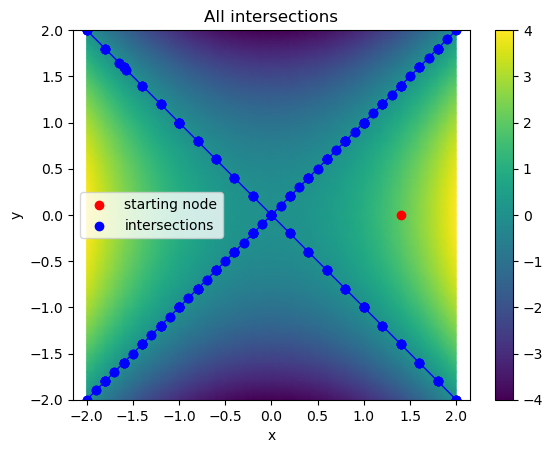

In [30]:
total_intersections = compute_intersections_OLD_VERSION(f,0.0)

# plot:
fig, ax = plt.subplots()
fig.colorbar(tripcolor(f, axes=ax))
tricontour(f, levels=[0], colors='blue', linewidths=1, axes=ax)
plt.scatter(pt[0], pt[1], color='red', label='starting node')
plt.scatter(*zip(*total_intersections), color='blue', label='intersections')
plt.title(r"All intersections")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()